In [462]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

In [463]:
FILES_PATH = "/home/guillaume/pythia/code/data/"

In [464]:
fixtures_data = pd.read_csv(f"{FILES_PATH}fixtures.csv", delimiter=",")
odds_data = pd.read_csv(f"{FILES_PATH}odds.csv", delimiter=",")
players_data = pd.read_csv(f"{FILES_PATH}players.csv", delimiter=",")
results_data = pd.read_csv(f"{FILES_PATH}results.csv", delimiter=",")
startingXI_data = pd.read_csv(f"{FILES_PATH}startingXI.csv", delimiter=",")
teams_data = pd.read_csv(f"{FILES_PATH}teams.csv", delimiter=",")

In [465]:
results_data = results_data.merge(teams_data, left_on="HomeTeamID", right_on = "TeamID", how="left")\
    .rename(columns = {"TeamName" : "HomeTeamName"})\
        .drop(columns="TeamID")

results_data = results_data.merge(teams_data, left_on="AwayTeamID", right_on = "TeamID", how="left")\
    .rename(columns = {"TeamName" : "AwayTeamName"})\
        .drop(columns="TeamID")

## Feature engineering
- It is tempting to add a time parameter since teams can potentially ramp up or on the contrary, crash throughout the season. However, since we only have one season available for training, this variable would likely be irrelevant. 

### Measure impact of home vs away

In [466]:
plt.hist(results_data["HomeShotConversion"])
plt.hist(results_data["AwayShotConversion"])

KeyError: 'HomeShotConversion'

(array([ 88., 393., 436., 256., 209.,  74.,  31.,  18.,   3.,   4.]),
 array([ 1. ,  4.7,  8.4, 12.1, 15.8, 19.5, 23.2, 26.9, 30.6, 34.3, 38. ]),
 <BarContainer object of 10 artists>)

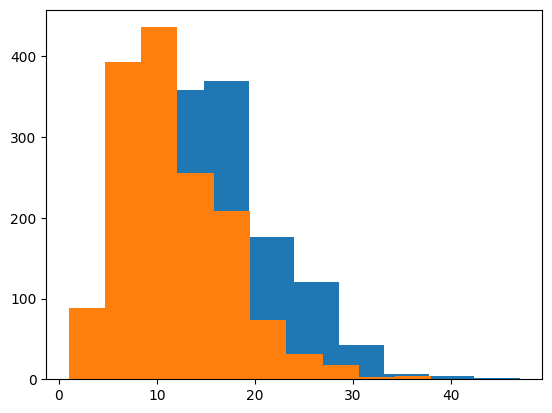

In [467]:
plt.hist(results_data["HomeShots"])
plt.hist(results_data["AwayShots"])

In [468]:
results_data["HomeAttackRate"] = results_data["HomeScore"]/results_data["HomeShots"]
results_data["AwayAttackRate"] = results_data["AwayScore"]/results_data["AwayShots"]

results_data["HomeDefenseRate"] = 1-results_data["AwayScore"]/results_data["AwayShots"]
results_data["AwayDefenseRate"] = 1-results_data["HomeScore"]/results_data["HomeShots"]

(array([  1.,   0.,   3.,  24.,  55., 128., 252., 276., 365., 408.]),
 array([0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 10 artists>)

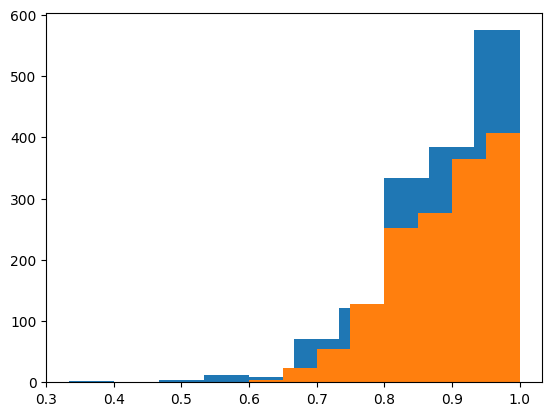

In [469]:
plt.hist(results_data["HomeDefenseRate"])
plt.hist(results_data["AwayDefenseRate"])

## Feature engineering on players

Let's first check if any players with the same name.

In [470]:
players_data[players_data["PlayerName"].duplicated()]
## It is important to make the distinctions between these players who share their name with at least another player.

,PlayerName,TeamID,PositionID
92,Frank Smith,12,3
414,Fred Williams,24,3
650,Robert Pitts,8,1


We create a unique ID for every player

In [471]:
players_data["PlayerID"] = np.arange(1, len(players_data)+1)

### Add team ID to the dataset using players' name

In [472]:
homonymous_player_names = players_data[players_data["PlayerName"].duplicated()]["PlayerName"].values
player_names = startingXI_data["StartingXI"][0].split(",")

def link_players_to_teamID(player_names : list, homonymous_player_names : list = homonymous_player_names)->str:
    for _name in player_names:
        if _name not in homonymous_player_names:
            return players_data[players_data["PlayerName"]==_name]["TeamID"].values[0]
        else: 
            continue

startingXI_data["StartingXI"] = startingXI_data["StartingXI"].map(lambda x: x.split(","))
startingXI_data["TeamID"] = startingXI_data["StartingXI"].map(lambda x: link_players_to_teamID(x))

### Explode the dataframe to get one player per row, per game, per team

In [474]:
startingXI_data_exploded = startingXI_data.copy()
startingXI_data_exploded = startingXI_data_exploded.explode("StartingXI").rename(columns = {"StartingXI" : "PlayerName"})
startingXI_data_exploded = startingXI_data_exploded.merge(players_data, on = ["PlayerName", "TeamID"], how = "left")
startingXI_data_exploded["MatchPlayed"] = 1 ## This variable will be useful later on for any calculations (e.g.: to count the number of games played)

### Check the number of formations used throughout the two seasons

In [475]:
formation_data = startingXI_data_exploded.groupby(["MatchID", "TeamID", "PositionID"]).agg(
    {"MatchPlayed" : "sum"}
).reset_index().sort_values(by=["MatchID", "TeamID", "PositionID"]).groupby(["MatchID", "TeamID"]).agg(
    {"MatchPlayed":list}
).reset_index().rename(columns={"MatchPlayed" : "MatchFormation"})

set(tuple(i) for i in formation_data["MatchFormation"])

{(1, 3, 5, 2), (1, 4, 3, 3), (1, 4, 4, 2)}

We add the number of defenders, midfielders, forwards for each team and every game

In [476]:
formation_data["NumberDefenders"] = formation_data.apply(lambda x: x.MatchFormation[1], axis=1)
formation_data["NumberMidfielders"] = formation_data.apply(lambda x: x.MatchFormation[2], axis=1)
formation_data["NumberForwards"] = formation_data.apply(lambda x: x.MatchFormation[3], axis=1)
formation_data

,MatchID,TeamID,MatchFormation,NumberDefenders,NumberMidfielders,NumberForwards
0,1,1,"[1, 4, 3, 3]",4,3,3
1,1,7,"[1, 4, 3, 3]",4,3,3
2,2,6,"[1, 3, 5, 2]",3,5,2
3,2,8,"[1, 4, 3, 3]",4,3,3
4,3,5,"[1, 4, 4, 2]",4,4,2
...,...,...,...,...,...,...
3019,1510,17,"[1, 3, 5, 2]",3,5,2
3020,1511,13,"[1, 4, 3, 3]",4,3,3
3021,1511,16,"[1, 4, 3, 3]",4,3,3
3022,1512,14,"[1, 4, 3, 3]",4,3,3


### Explore formation of players for every game

In [477]:
all_combinations = startingXI_data_exploded.sort_values(by=["MatchID", "TeamID", "PositionID", "PlayerID"]).groupby(["MatchID", "TeamID", "PositionID"]).agg(
    {"PlayerID" : list}
).reset_index().groupby(["MatchID", "TeamID"]).agg(
    {"PlayerID":list}
).reset_index()

all_combinations

,MatchID,TeamID,PlayerID
0,1,1,"[[2], [4, 6, 8, 9], [15, 17, 18], [20, 22, 25]]"
1,1,7,"[[628], [631, 634, 635, 636], [641, 642, 644],..."
2,2,6,"[[601], [604, 609, 611], [612, 613, 614, 617, ..."
3,2,8,"[[652], [654, 656, 660, 661], [664, 665, 668],..."
4,3,5,"[[578], [582, 584, 585, 586], [587, 588, 591, ..."
...,...,...,...
3019,1510,17,"[[203], [205, 206, 207], [212, 214, 215, 217, ..."
3020,1511,13,"[[101], [105, 108, 110, 111], [115, 116, 117],..."
3021,1511,16,"[[176], [179, 180, 184, 186], [189, 192, 193],..."
3022,1512,14,"[[128], [129, 131, 133, 136], [137, 138, 140],..."


In [478]:
all_combinations["StartingGoalkeeper"] = all_combinations.apply(lambda x: x.PlayerID[0], axis=1)
all_combinations["StartingDefenders"] = all_combinations.apply(lambda x: x.PlayerID[1], axis=1)
all_combinations["StartingMidfielders"] = all_combinations.apply(lambda x: x.PlayerID[2], axis=1)
all_combinations["StartingForwards"] = all_combinations.apply(lambda x: x.PlayerID[3], axis=1)
all_combinations = all_combinations.drop(columns = ["PlayerID"])

In [479]:
all_combinations = all_combinations.merge(results_data, on = ["MatchID"], how = "left")

We add the Boolean: was the game home or away?

In [480]:
all_combinations["Home"] = all_combinations.apply(lambda x : 1 if x.HomeTeamID ==x.TeamID else 0, axis = 1)

## Goalkeeper score calculation

In [481]:
team_data = all_combinations.copy()
team_data = team_data[team_data["TeamID"]==1]

In [482]:
total_list = []
for i in range(len(team_data)//4):
    total_list += 4*[i//4]

team_data["GameSeries"] = total_list

In [499]:
results_with_players = startingXI_data_exploded.merge(results_data, on = ["MatchID"], how = "left")

In [500]:
results_with_players["TeamScore"] = results_with_players.apply(lambda x : x.HomeScore if x.TeamID == x.HomeTeamID else x.AwayScore, axis=1)
results_with_players["OpponentScore"] = results_with_players.apply(lambda x : x.AwayScore if x.TeamID == x.HomeTeamID else x.HomeScore, axis=1)
results_with_players = results_with_players.drop(columns = ["HomeScore", "AwayScore"])


results_with_players["TeamShots"] = results_with_players.apply(lambda x : x.HomeShots if x.TeamID == x.HomeTeamID else x.AwayShots, axis=1)
results_with_players["OpponentShots"] = results_with_players.apply(lambda x : x.AwayShots if x.TeamID == x.HomeTeamID else x.HomeShots, axis=1)
results_with_players = results_with_players.drop(columns = ["HomeShots", "AwayShots"])


In [501]:
results_with_players = results_with_players.sort_values(by = ["PlayerID", "MatchID"], ascending=True).reset_index()

results_with_players["SumGoalsXGames"] = results_with_players\
        .groupby(["PlayerID"])["OpponentScore"]\
            .rolling(window=4).sum().reset_index(drop=True)

results_with_players["SumShotsXGames"] = results_with_players\
        .groupby(["PlayerID"])["OpponentShots"]\
            .rolling(window=4).sum().reset_index(drop=True)

In [502]:
results_with_players[(results_with_players["TeamID"]==1) & (results_with_players["PlayerID"]==1)]

,index,MatchID,PlayerName,TeamID,PositionID,PlayerID,MatchPlayed,SeasonID,Gameweek,HomeTeamID,...,HomeAttackRate,AwayAttackRate,HomeDefenseRate,AwayDefenseRate,TeamScore,OpponentScore,TeamShots,OpponentShots,SumGoalsXGames,SumShotsXGames
0,319,15,Odell Williams,1,1,1,1,1,2,2,...,0.000000,0.111111,0.888889,1.000000,2,0,18,9,NaN,NaN
1,924,43,Odell Williams,1,1,1,1,1,4,1,...,0.062500,0.083333,0.916667,0.937500,1,1,16,12,NaN,NaN
2,4015,183,Odell Williams,1,1,1,1,1,14,14,...,0.090909,0.000000,1.000000,0.909091,0,1,8,11,NaN,NaN
3,4312,197,Odell Williams,1,1,1,1,1,15,1,...,0.000000,0.076923,0.923077,1.000000,0,1,9,13,3.0,45.0
4,5852,267,Odell Williams,1,1,1,1,1,20,1,...,0.052632,0.071429,0.928571,0.947368,1,1,19,14,4.0,50.0
5,6160,281,Odell Williams,1,1,1,1,1,21,1,...,0.000000,0.100000,0.900000,1.000000,0,1,11,10,4.0,48.0
6,7392,337,Odell Williams,1,1,1,1,1,25,1,...,0.142857,0.142857,0.857143,0.857143,1,1,7,7,4.0,44.0
7,7711,351,Odell Williams,1,1,1,1,1,26,24,...,0.000000,0.000000,1.000000,1.000000,0,0,9,14,3.0,45.0
8,8943,407,Odell Williams,1,1,1,1,1,30,20,...,0.142857,0.105263,0.894737,0.857143,2,1,19,7,3.0,38.0
9,9548,435,Odell Williams,1,1,1,1,1,32,1,...,0.187500,0.000000,1.000000,0.812500,3,0,16,6,2.0,34.0
